In [ ]:
#EMULADOR MRE provisto por la cátedra

"""
Created on Wed Aug 19 10:18:45 2020

@author: Waldo Hasperué

@version: 0.5
@release: Sep 26, 2022

    TODO: emular varios nodos reducers para que haya más de una salida
    TODO: emular varios threads en un nodo mapper

"""

from os import scandir, unlink, mkdir
from os.path import isdir, isfile
from random import shuffle

InputKeyValueSeparator = "\t"
OutputKeyValueSeparator = "\t"
MaxForCombiner = 10
NumOfMappers = 10
NumOfReducer = 10

class MRE_Exception(Exception):
    pass

class _TreeNode:
    def __init__(this, key, value):
        this.__key = key
        this.__values = [(key, value)]
        this.__left = None
        this.__right = None

    def _getValues(this):
        return this.__values

    def print(this):
        if not(this.__left is None):
            this.__left.print()

        print(str(this.__key) + " ==> " + str(this.__values))

        if not(this.__right is None):
            this.__right.print()

    def getKey(this):
        return this.__key

    def getLeft(this):
        return this.__left

    def getRight(this):
        return this.__right

    def setLeft(this, left):
        this.__left = left

    def setRight(this, right):
        this.__right = right

    def add(this, value):
        this.__values.append(value)

    def count(this):
        return len(this.__values)

    def getAndEmptyValues(this):
        v=[]
        for t in this.__values:
            v.append(t[1])
        this.__values = []
        return v

    def getAllValues(this, values):
        if not(this.__left is None):
            this.__left.getAllValues(values)

        for t in this.__values:
            values.append(t[1])

        if not(this.__right is None):
            this.__right.getAllValues(values)

    def __addOrUpdate(this, aTree, key, value, cmp):
        if aTree is None:
            aTree = _TreeNode(key, value)
        else:
            _tree = aTree
            buscar = True
            while buscar:
                c = cmp(key, _tree.getKey())
                if c == 0:
                    _tree.add((key, value))
                    buscar = False
                elif c < 0:
                    if(_tree.getLeft() is None):
                        _tree.setLeft(_TreeNode(key, value))
                        buscar = False
                    else:
                        _tree = _tree.getLeft()
                else:
                    if(_tree.getRight() is None):
                        _tree.setRight(_TreeNode(key, value))
                        buscar = False
                    else:
                        _tree = _tree.getRight()
        return aTree

    def collect(this, dic, fsort):
        # Cada nodo de este árbol representa una clave intermedia y su lista de valores asociados
        nodos = [this]
        while len(nodos) > 0:
            _tree = nodos[0]
            del(nodos[0])
            tmpTree = None        # a _TreeNode
            for t in _tree._getValues():
                tmpTree = this.__addOrUpdate(tmpTree, t[0], t[1], fsort)
            values = []

            #if tmpTree <> None:
            # TODO: Revisar, cuando en una función combiner se escribe una nueva clave (no generada por los mappers)
            # tmpTree queda en None
            tmpTree.getAllValues(values)
            dic[_tree.__key] = values

            if not(_tree.getLeft() is None):
                nodos.append(_tree.getLeft())

            if not(_tree.getRight() is None):
                nodos.append(_tree.getRight())

def fDefaultCmp(a, b):
    if a == b:
        return 0
    elif a < b:
        return -1
    else:
        return 1

class _NodeMapIterator:
    def __init__(this):
        this.__lines = []

    def add(this, line):
        this.__lines.append(line)

    def __iter__(this):
        this.__currentLine = 0
        return this

    def __next__(this):
        if this.__currentLine < len(this.__lines):
            n = this.__lines[this.__currentLine]
            this.__currentLine+= 1
            return n;
        else:
            raise StopIteration

class _Cluster:
    def __init__(this, inputs):
        this.__nodes = []
        for i in range(NumOfMappers):
            this.__nodes.append(_NodeMapIterator())

        lines = []
        for i in inputs:
            files = [obj.name for obj in scandir(i[0]) if obj.is_file()]
            for f in files:
                file = open(i[0] + "/" + f, "r", encoding='latin-1')
                lines.append((i[1], file.readlines()))
                file.close()
        shuffle(lines)

        n=0
        for (f,lin) in lines:
            offset = 0
            for l in lin:
                l = l[:-1]
                if(l.find(InputKeyValueSeparator) >= 0):
                    (k,v) = l.split(InputKeyValueSeparator, 1)
                else:
                    (k,v) = (offset, l)
                    offset+= len(l)

                this.__nodes[n].add((f, k, v))
                n+=1
                if n >= NumOfMappers:
                    n = 0

        this.__currentNode = 0

    def __next__(this):
        if this.__currentNode < NumOfMappers:
            n = this.__nodes[this.__currentNode]
            this.__currentNode+= 1
            return n;
        else:
            raise StopIteration

class _Context:
    def __init__(this, _inputs, inter, output, fComb, params, fShuffleCmp, fSortCmp):
        this.__inputs = _inputs
        this.__stage = 0 #map
        this.__output = output
        this.__interDir = inter

        this.__interm = None      # a _TreeNode
        this.__result = []

        this.__params = params
        this.__fComb = fComb
        this.__fShuffleCmp = fShuffleCmp
        this.__fSortCmp = fSortCmp

    def __iter__(this):
        if(this.__stage == 0):
            return _Cluster(this.__inputs)
            #return _MapIterator(this.__inputs)
        elif(this.__stage == 3):
            _dict = {}
            if not (this.__interm is None):
                this.__interm.collect(_dict, this.__fSortCmp)
            return _Reduceterator(_dict)
        else:
            return None

    def createOrCleanDir(this, _dir):
        if (isdir(_dir)):
            files = [obj.name for obj in scandir(_dir) if obj.is_file()]
            for f in files:
                fp = _dir + "/" + f
                if isfile(fp):
                    unlink(fp)
        else:
            mkdir(_dir)

    def finish(this):
        this.createOrCleanDir(this.__output)
        f = open(this.__output + "/output.txt", "w+")
        for t in this.__result:
            f.write(this.__flat(t[0]) + OutputKeyValueSeparator + this.__flat(t[1]) + "\n")
        f.close()

    def __flat(this, obj):
        if(type(obj) is tuple) or (type(obj) is list):
            res = ""
            for v in obj:
                res = res + this.__flat(v) + OutputKeyValueSeparator
            res = res[:-1]
        else:
            res = str(obj)

        return res

    def __isIterable(this, obj):
        return type(obj) in [tuple, list, dict, set]

    def startReduce(this):
        this.__stage = 3 # reduce
        if (not(this.__interDir is None)) and (not (this.__interm is None)):
            # guardar a disco
            this.createOrCleanDir(this.__interDir)
            f = open(this.__interDir + "/output.txt", "w+")
            _dict = {}
            this.__interm.collect(_dict, this.__fSortCmp)

            for t in _dict.keys():
                for v in _dict[t]:
                    s = this.__flat(t) + "\t"
                    if(this.__isIterable(v)):
                        for vv in v:
                            s = s + this.__flat(vv)
                    else:
                        s = s + str(v) + "\t"
                    f.write(s + "\n")
            f.close()

    def __addOrUpdateKey(this, aTree, key, value, cmp):
        if aTree is None:
            aTree = _TreeNode(key, value)
        else:
            buscar = True
            _tree = aTree
            while buscar:
                c = cmp(key, _tree.getKey())
                if c == 0:
                    _tree.add((key, value))
                    if(_tree.count() > MaxForCombiner):
                        this.__executeCombiner(_tree)
                    buscar = False

                elif c < 0:
                    if(_tree.getLeft() is None):
                        _tree.setLeft( _TreeNode(key, value) )
                        buscar = False
                    else:
                        _tree = _tree.getLeft()
                else:
                    if(_tree.getRight() is None):
                        _tree.setRight( _TreeNode(key, value) )
                        buscar = False
                    else:
                        _tree = _tree.getRight()
        return aTree

    def write(this, k, v):
		# TODO: Cuando escribe un combiner chequear que no se cambie la clave intermedia

        if (this.__stage == 0):
            # map
            this.__interm = this.__addOrUpdateKey(this.__interm, k, v, this.__fShuffleCmp)

        elif (this.__stage == 3):
            # reduce
            if (type(k) == ValuesIterator) or (type(v) == ValuesIterator):
                raise MRE_Exception("No es posible escribir la lista de valores. Recorrala con un for y escriba los elementos por separado; o use el método next() si sabe que la lista de values solo tiene un elemento.")
            this.__result.append((k, v))

    def __getitem__(this, index):
        return this.__params[index]

    def __executeCombiner(this, tree):
        if(this.__fComb is None):
            return

        values = tree.getAndEmptyValues()

        this.__fComb(tree.getKey(), values, this)


class _MapIterator:
    def __init__(this, _inputs):
        this.__inputs = _inputs
        this.__currentInput = 0
        this.__initInput(this.__currentInput)

    def __initInput(this, ci):
        if ci < len(this.__inputs):
            this.__currentDir = this.__inputs[ci][0]
            this.__currentFuncMap = this.__inputs[ci][1]
            if(this.__currentFuncMap is None):
                this.__currentInput = this.__currentInput + 1
                return this.__initInput(this.__currentInput)
            else:
                this.__files = [obj.name for obj in scandir(this.__currentDir) if obj.is_file()]
        else:
            this.__files = []
        this.__currentFile = 0
        this.__initFile(this.__currentFile)

    def __initFile(this, cf):
        if cf < len(this.__files):
            f = open(this.__currentDir + "/" + this.__files[cf], "r", encoding='latin-1')
            this.__lines = f.readlines()
            shuffle(this.__lines)
            f.close()
        else:
            this.__lines = []
        this.__currentLine = 0
        this.__offset = 0

    def __next__(this):
        if(this.__currentInput >= len(this.__inputs)):
            raise StopIteration

        elif(this.__currentFile >= len(this.__files)):
            this.__currentInput = this.__currentInput + 1
            this.__initInput(this.__currentInput)
            return this.__next__()

        elif (this.__currentLine >= len(this.__lines)):
            this.__currentFile = this.__currentFile + 1
            this.__initFile(this.__currentFile)
            return this.__next__()

        else:
            line = this.__lines[this.__currentLine]
            line = line[:-1]
            if(line.find(InputKeyValueSeparator) >= 0):
                (k,v) = line.split(InputKeyValueSeparator, 1)
            else:
                (k,v) = (this.__offset, line)
            this.__offset = this.__offset + len(this.__lines[this.__currentLine])
            this.__currentLine = this.__currentLine + 1
            return (this.__currentFuncMap, k,v)

class ValuesIterator:
        def __init__(this, l):
            this.__values = l
            this.__currentValue = 0
            this.__firstTime = True

        def __iter__(this):
            if (this.__firstTime):
                this.__firstTime = False
                return this
            else:
                raise MRE_Exception("No es posible recorrer la lista de valores más de una vez. Deberá hacer todas las operaciones dentro de un único for.")

        def __next__(this):
            if this.__currentValue >= len(this.__values):
                raise StopIteration
            else:
                this.__currentValue = this.__currentValue + 1
                return this.__values[this.__currentValue - 1]

        def next(this):
            try:
                return this.__next__()
            except StopIteration:
                return None

class _Reduceterator:
    def __init__(this, _dict):
        this.__dict = _dict
        this.__keys = list(this.__dict.keys())
        this.__keys.sort()
        this.__currentKey = 0

    def __next__(this):
        if(this.__currentKey >= len(this.__keys)):
            raise StopIteration
        else:
            k = this.__keys[this.__currentKey]
            v = this.__dict[k]
            this.__currentKey = this.__currentKey + 1
            return (k, ValuesIterator(v))

class Job:
    def __init__(this, _input, output, fMap, fReduce):
        this.__inputs = [(_input, fMap)]
        this.__fReduce = fReduce
        this.__fComb = None
        this.__output = output
        this.__params = None
        this.__fShuffleCmp = fDefaultCmp
        this.__fSortCmp = fDefaultCmp
        this.__interDir = None

    def setNumReducers(this, n):
        this.__numReducers = n

    def setIntermDir(this, d):
        this.__interDir = d

    def setShuffleCmp(this, fShuffleCmp):
        this.__fShuffleCmp = fShuffleCmp

    def setSortCmp(this, fSortCmp):
        this.__fSortCmp = fSortCmp

    def setParams(this, params):
        this.__params = params

    def setCombiner(this, fComb):
        this.__fComb = fComb

    def __map(this, context):
        for n in context:
            for (f, k, v) in n:
                f(k, v, context)

    def __shuffle(this, context):
        pass

    def __sort(this, context):
        pass

    def __reduce(this, context):
        context.startReduce()
        for (k,vs) in context:
            this.__fReduce(k, vs, context)

    def waitForCompletion(this):
        context = _Context(this.__inputs, this.__interDir, this.__output, this.__fComb, this.__params, this.__fShuffleCmp, this.__fSortCmp)
        this.__map(context)
        this.__shuffle(context)
        this.__sort(context)
        this.__reduce(context)
        context.finish()

        return True

    def addInputPath(this, _input, fmap):
        this.__inputs.append((_input, fmap))



El índice TF-IDF es un indicador de la relevancia de un término (palabra) que aparece en un documento en relación a su aparición en un conjunto de documentos. Su cálculo es el siguiente:

**TF-IDF(t,d,D) = TF(t,d) . IDF(t,D)**

Donde:
**TF(t,d) = ft(d) / #d**

Donde **ft(d)** es la cantidad de veces que aparece el término t en el documento d y **#d** es la cantidad de palabras total del documento d.


**IDF(t, D) = log (#D / D(t) )**

Donde **#D** es la cantidad de documentos totales y
**D(t)** es la cantidad de documentos que contienen al menos una vez el término t.


# Diseño de los Jobs:
-----
## Job 1: Calcula cantidad de ocurrencias de la palabra enviada por parámetro en cada review, adicionalmente se queda con la cantidad total de palabras del review para evitar contarlas en un job separado (evitando recorrer nuevamente todos los archivos big data)
* Map: (doc_id, cantOcurrenciasPalabra, cantidadPalabrasDoc)
* Reduce: (doc_id, cantOcurrenciasPalabra, cantidadPalabrasDoc)

-----
## Job 2: Calcula la cantidad de documentos
* Map: (doc_id, 1)
* Reduce: (Count_Docs, 1) #genera sólo un registro con la cantidad de documentos
-----

## Job 3: Calcula en cuantos documentos aparece el término
* Map: (1 o 0 según si está el término o no, doc_id)
* Reduce: (Count_Docs_Termino, 1) #genera sólo un registro con la cantidad de documentos que tienen la palabra

-----
### Notar que ni Job 2 ni Job 3 retornan BigData, cada uno genera sólo una tupla con un número de interés, luego se leerá para que se transforme en input por parámetro del último Job 4 que calculará efectivamente el TF-IDF por cada Review para la palabra dada

-----
## Job 4: Calcula TF-IDF de cada palabra de cada documento
   Dado que ya cuenta con ocurrencias de la palabra dada en cada documento, la cantidad de palabras en cada documento, la cantidad de documentos y la cantidad de documentos que aparece la palabra (jobs 1, 2 y 3), se puede calcular en esta última fase el TF-IDF
   
* Map: (doc_id, (cantOcurrenciasPalabraEnDoc, cantTotalPalabrasDoc))
* Reduce: (doc_id, tf-idf)
-----

DAG:

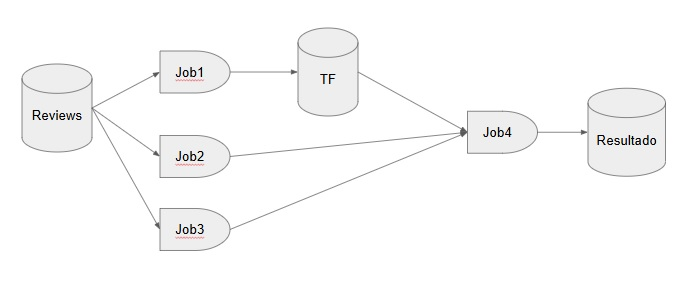

In [ ]:
print("IMPORTANTE: Antes de continuar ejecutando crear directorio input/ y agregar ahí todos los reviews")

IMPORTANTE: Antes de continuar ejecutando crear directorio input/ y agregar ahí todos los reviews


In [ ]:
import datetime, math, re
import random

# Importamos el emulador
#from mre import Job #YA LO  TENGO EN CÓDIGO EN ESTE MISMO NOTEBOOK

root_path = './'
inputDir = root_path + "input/"
outputDir = root_path + "output/"
outputDir2 = root_path + "output2/"
outputDir3 = root_path + "output3/"
outputDirFinal = root_path + "outputFinal/"

In [ ]:


#JOB 1:
####################################################################################################
#task de conteo de ocurrencias de la palabra en el documento y cantidad de palabras del documento
def fmap1(key, value, context):
    words = re.split(';|,| |\.|-|!|\t|\"|&|\(|\)|\*|<|>|/|:|\'', value.lower())
    cantTotalPalabras = len(words)
    cantOcurrencias = 0
    for w in words:
       if w == context['wordToSearch']: cantOcurrencias = cantOcurrencias + 1
    context.write(key, (cantOcurrencias, cantTotalPalabras))


              #####      seguir desde acá, antes agregue cantidad de palabras total en doc

#Este reduce simplemente guarda lo ya calculado en fmap1
def fred1(key, values, context):
  for v in values:
    context.write(key, v)
#####################################################################################################



#JOB 2:
####################################################################################################
#sólo calcula la cantidad de reviews (bigData):
def fmap2(key, value, context):
    context.write(1, key) #guardo (1,key) (simplemente para que luego el reduce cuente la cantidad de docs)

#Como resultado de este reduce queda una única tupla con la cantidad de documentos
#observación: No está optimizado ya que fuerza a que sólo una instancia de reduce reciba el cálculo, podría optimizarse
#generando por ejemplo random en la key generada por el map (en lugar de siempre 1) así trabajan varios reduce, luego
#el archivo resultante NO sería big data y podría iterarse para calcular el total de documentos.
def fred2(key, values, context):
    totalReviews = 0
    for v in values:
        totalReviews = totalReviews + 1
    context.write(totalReviews, 0)
####################################################################################################

# JOB 3:
####################################################################################################
#Recorre todos los reviews contando si aparece la palabra en cada uno
def fmap3(key, value, context):
    words = re.split(';|,| |\.|-|!|\t|\"|&|\(|\)|\*|<|>|/|:|\'', value.lower())
    if context['wordToSearch'] in words:
        context.write(1, key)

def fred3(key, values, context):
    count = 0
    for v in values:
        count = count + 1
    context.write(count, 0)
####################################################################################################


In [ ]:
#leo de teclado la palabra a calcular su TF-IDF entre todos los reviews
palabra = input("ingrese una palabra a evaluar su TF-IDF:")
params = {"wordToSearch": palabra}

job = Job(inputDir, outputDir, fmap1, fred1)
job.setParams(params)
success = job.waitForCompletion()
print("Job1", success)

job2 = Job(inputDir, outputDir2, fmap2, fred2)
success = job2.waitForCompletion()
print("Job2", success)

job3 = Job(inputDir, outputDir3, fmap3, fred3)
job3.setParams(params)
success = job3.waitForCompletion()
print("Job3", success)


ingrese una palabra a evaluar su TF-IDF:movies
Job1 True
Job2 True
Job3 True


In [ ]:
#Calculo IDF(t,D) desde los resultados de job2 (CantTotalDocumentos) y job3 (CantDocumentosConTermino)

# Función para leer el valor de una tupla desde un archivo
def leer_valor_de_archivo(ruta_archivo):
    with open(ruta_archivo, 'r') as archivo:
        contenido = archivo.read().strip()
        # Convertir el contenido de texto en una tupla de Python
        tupla = contenido.split('\t')
        return tupla[0]  # Devuelve el primer elemento de la tupla

# Rutas de los archivos resultantes de job2 y job3:
ruta_archivo_output2 = root_path + "output2/output.txt"
ruta_archivo_output3 = root_path + "output3/output.txt"


cantDocs = leer_valor_de_archivo(ruta_archivo_output2)
cantDocsConTermino = leer_valor_de_archivo(ruta_archivo_output3)

# Calcular el logaritmo de la división entre CantDocs y CantDocsConTermino
if float(cantDocsConTermino) != 0:  # Asegurar que Cant2 no sea cero para evitar división por cero
      IDF = math.log(float(cantDocs) / float(cantDocsConTermino))
else:
      IDF= 0
print('cantDocsConTermino', float(cantDocsConTermino))
print('cantDocs', float(cantDocs))
print('IDF', IDF)

params = {"IDF": IDF}

# JOB 4:
####################################################################################################
#Calcula el TF-IDF para la palabra dada en cada uno de los reviews
def fmap4(key, value, context):
    elems = value.split("\t")
    tf = float(elems[0])/float(elems[1])
    context.write(key, tf*context['IDF'])


def fred4(key, values, context):
  for v in values:
    context.write(key, v)

####################################################################################################

job4 = Job(outputDir, outputDirFinal, fmap4, fred4)
job4.setParams(params)
success = job4.waitForCompletion()
print("Job4", success)
print("Revisar en directorio outputFinal el archivo que tiene para cada review el valor TF-IDF para la palabra ingresada")



cantDocsConTermino 2.0
cantDocs 10.0
IDF 1.6094379124341003
Job4 True
Revisar en directorio outputFinal el archivo que tiene para cada review el valor TF-IDF para la palabra ingresada
